## Generate Solutions to the Sod Shock Problem

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import sodshock

import pickle as pkl

In [50]:
data_path = "./data/"
n_sols = 5000

In [51]:
# sodshock.solve() defines state as (pressure p, density rho, velocity u)
# in the sod shock tube, initial velocity should be zero everywhere

def generate_sod_shock_solutions(data_path, n_sols=500, p_l_range=(1, 5), right_state=(0.1, 0.125, 0), geometry=(0., 1., 0.5), npts=500, t=0.1, gamma=1.4):
    """ Uses the sodshock package wrien by Isaac Backus, (https://github.com/ibackus/sod-shocktube/tree/master). Some of this documentation is directly copied from their repository.
        Generates n_sols total solutions to the sod shock tube problem in the low pressure ratio regime (1 <= p:rho <= 5) with left density set to 1 and standard right state.
    
        Args:
            data_path: str
                path for data to be stored at
            n_sols: int 
                # of solutions to be generated. default is 500
            p_l_range: tuple
                A tuple of the range for left pressure (low, high) to initialize the problem with. default is (1, 5) 
            right_state: tuple
                A tuple of the state (pressure, density, velocity) on the right side of the
                shocktube barrier for the ICs.  In the case of a dusty-gas, the density
                should be the gas density.
            geometry: tuple
                A tuple of positions for (left boundary, right boundary, barrier)
            t: float
                Time to calculate the solution at
            gamma: float
                Adiabatic index for the gas.
            npts: int
                number of points for array of pressure, density and velocity


        Returns:
            pkl file containing solutions
            positions: dict
                Locations of the important places (rarefaction wave, shock, etc...)
            regions: dict
                constant pressure, density and velocity states in distinct regions
            values: dict
                Arrays of pressure, density, and velocity as a function of position.
                The density ('rho') is the gas density
                Also calculates the specific internal energy
    """
    dataset = []
    left_pressure = np.linspace(p_l_range[0], p_l_range[1], n_sols)
    for n in range(n_sols):
        left_state = (left_pressure[n], 1, 0)
        positions, regions, values = sodshock.solve(left_state=left_state, right_state=right_state, geometry=geometry,npts=npts, t=t, gamma=gamma)
        
        x = values['x']
        p_final = values['p']
        rho_final = values['rho']
        u_final = values['u']
        
        # need to spatialize left_state, right_state
        barrier_loc = int(npts/2-1)
        p_init = np.zeros_like(p_final)
        rho_init = np.zeros_like(rho_final)
        u_init = np.zeros_like(u_final)
        
        # left_state
        for i in range(barrier_loc+1):
            p_init[i] = left_state[0]
            rho_init[i] = left_state[1]
            u_init[i] = left_state[2]
        
        # right state
        for i in range(barrier_loc+1, len(x)):
            p_init[i] = right_state[0]
            rho_init[i] = right_state[1]
            u_init[i] = right_state[2]
            
        init_conditions = [x, p_init, rho_init, u_init]
        final_sol = [p_final, rho_final, u_final]
        states = (left_state, right_state)
        dataset.append((init_conditions, final_sol, positions, regions, states))
    
    with open(data_path + "{0}_sod_shock_dataset.pkl".format(n_sols), "wb") as f:
        pkl.dump(dataset, f)


In [52]:
left_pressure = np.linspace(1, 5, 5000)
left_pressure

array([1.        , 1.00080016, 1.00160032, ..., 4.99839968, 4.99919984,
       5.        ])

# Generate and Save Initial Conditions and Solutions

In [53]:
generate_sod_shock_solutions(data_path=data_path, n_sols=n_sols)

In [54]:
#nsols = 501
#range = (1, 5)
#np.linspace(range[0], range[1], nsols)

## Split Train and Test Data

In [55]:
with open(data_path + "{0}_sod_shock_dataset.pkl".format(n_sols), "rb") as f:
    solutions = pkl.load(f)

# init_conditions, final_sol, positions, regions, states = solutions[0]
#init_conditions
#final_sol

In [56]:
import random
# 75 - 25% Train-Test Split
# Train on p in [1, 4), Test on p in (4, 5]
# random split

train_split = int(0.75 *len(solutions))
shuffled_solutions = random.sample(solutions, len(solutions))

print(train_split)
train_data = shuffled_solutions[:train_split]
train_input = []
train_output = []
for data in train_data:
    init_conditions, final_output, _, _, _ = data
    train_input.append(init_conditions)
    train_output.append(final_output)
    
test_data = shuffled_solutions[train_split:]
test_input = []
test_output = []
for data in test_data:
    init_conditions, final_output, _, _, _ = data
    test_input.append(init_conditions)
    test_output.append(final_output)

#for data in train_data:
#    _, _, _, _, states = data
#    print(states[0])

with open(data_path + "{0}_inputs_train.pkl".format(n_sols), "wb") as file:
    pkl.dump(train_input, file)

with open(data_path + "{0}_outputs_train.pkl".format(n_sols), "wb") as file:
    pkl.dump(train_output, file)
    
with open(data_path + "{0}_inputs_test.pkl".format(n_sols), "wb") as file:
    pkl.dump(test_input, file)
    
with open(data_path + "{0}_outputs_test.pkl".format(n_sols), "wb") as file:
    pkl.dump(test_output, file)
#len(train_data)    
#len(test_data)

3750


In [57]:
import torch
train_output = torch.as_tensor(train_output)
train_output.shape

torch.Size([3750, 3, 500])

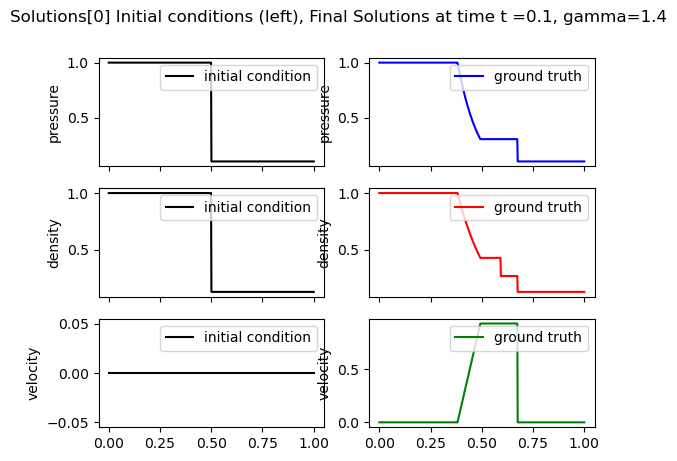

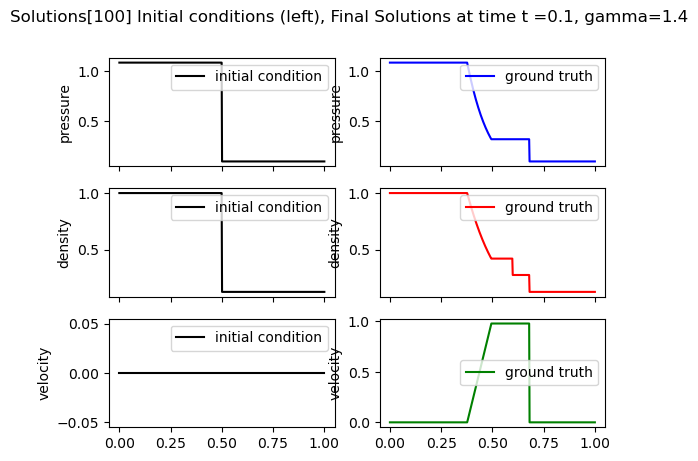

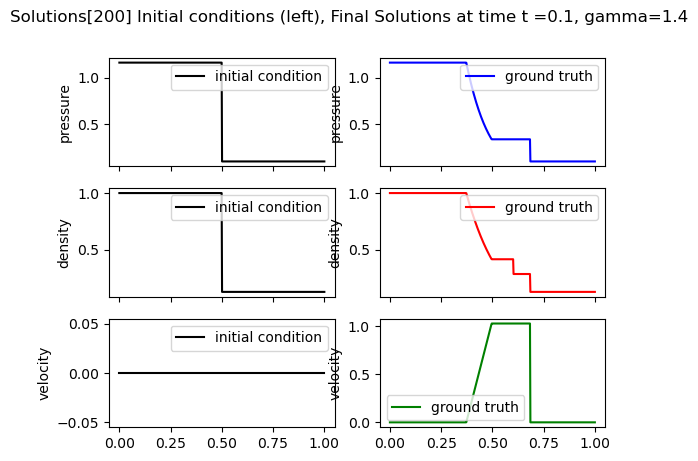

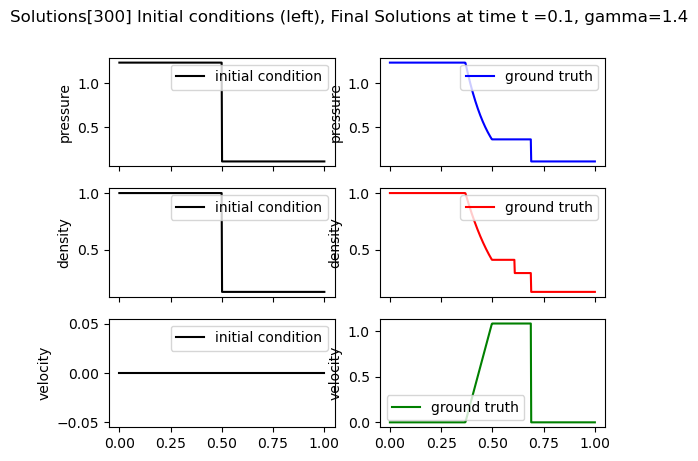

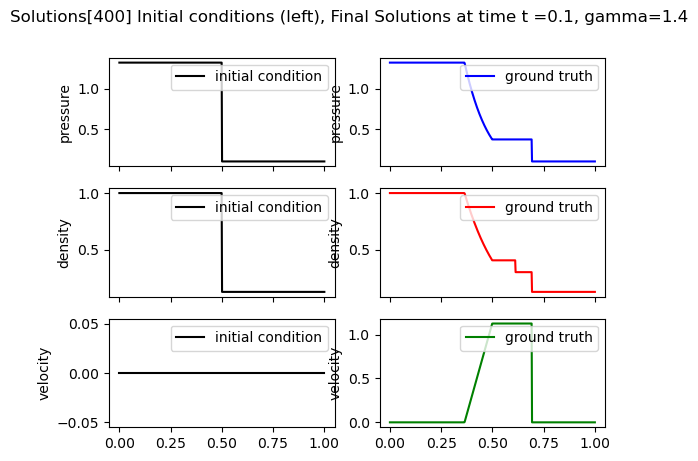

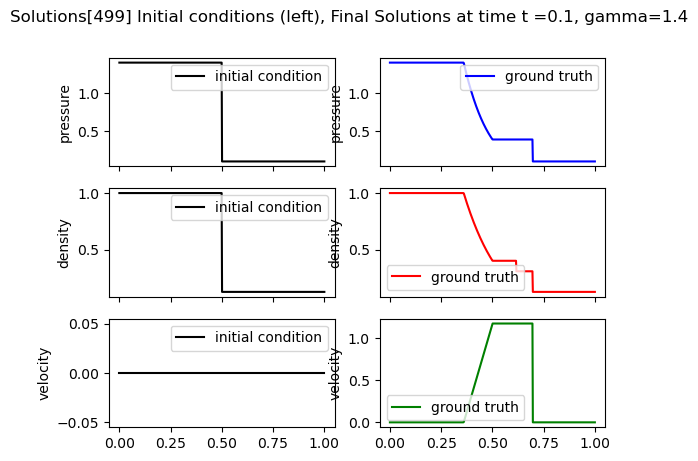

In [58]:
# visualize solutions 

for n in [0, 100, 200, 300, 400, 499]:
    inputs, outputs, _, _, _ = solutions[n]
    x, p_init, rho_init, u_init = inputs
    p_final, rho_final, u_final = outputs
    # Printing p, rho and u for regions

    # Finally, let's plot the solutions
    f, axarr = plt.subplots(3, 2, sharex=True)
    
    #x, p_init, rho_init, u_init = init_conditions
    #p_final, rho_final, u_final = final_sol
    axarr[0][0].plot(x, p_init, label="initial condition", linewidth=1.5, color='k')
    axarr[0][0].set_ylabel('pressure')
    axarr[0][0].legend()
    
    axarr[0][1].plot(x, p_final, label="ground truth", linewidth=1.5, color='b')
    axarr[0][1].set_ylabel('pressure')
    axarr[0][1].legend()
    # axarr[0].set_ylim(0, 5.1)
    
    axarr[1][0].plot(x, rho_init, label="initial condition", linewidth=1.5, color='k')
    axarr[1][0].set_ylabel('density')
    axarr[1][0].legend()
    
    axarr[1][1].plot(x, rho_final, label="ground truth", linewidth=1.5, color='r')
    axarr[1][1].set_ylabel('density')
    axarr[1][1].legend()
    # axarr[1][1].set_ylim(0, 1.1)
    
    axarr[2][0].plot(x, u_init, label="initial condition", linewidth=1.5, color='k')
    axarr[2][0].set_ylabel('velocity')
    axarr[2][0].legend()
    
    axarr[2][1].plot(x, u_final, label="ground truth", linewidth=1.5, color='g')
    axarr[2][1].set_ylabel('velocity')
    axarr[2][1].legend()
        
    plt.suptitle('Solutions[{2}] Initial conditions (left), Final Solutions at time t ={0}, gamma={1}'.format(0.1, 1.4, n))
    plt.show()


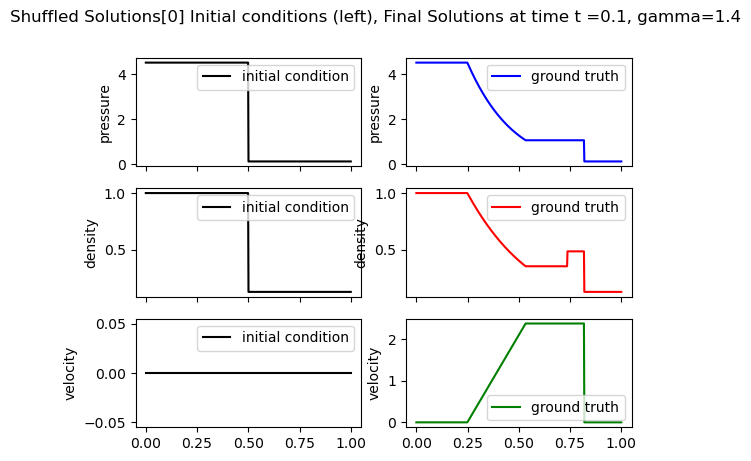

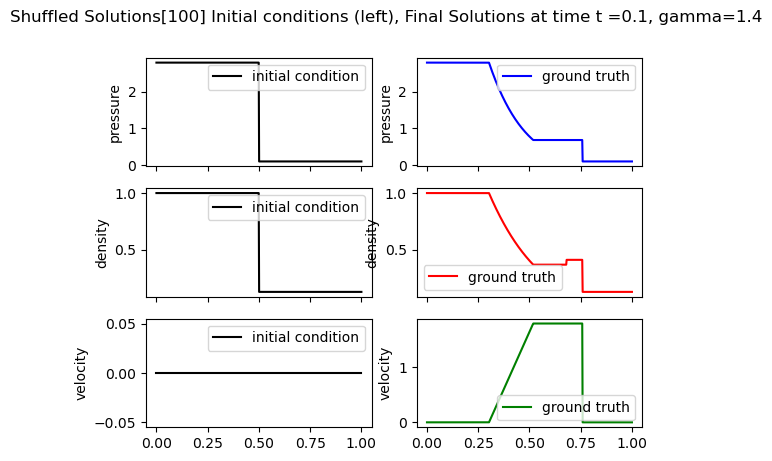

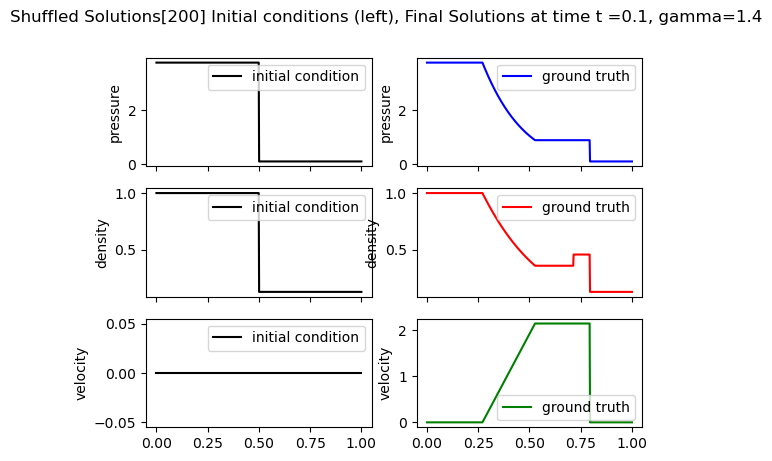

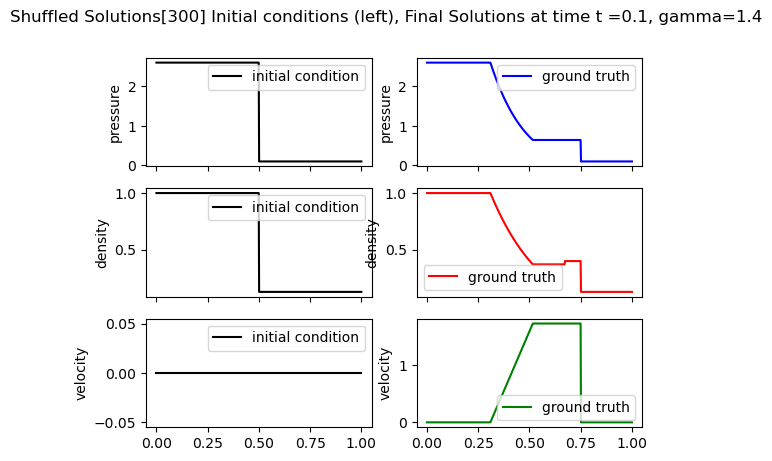

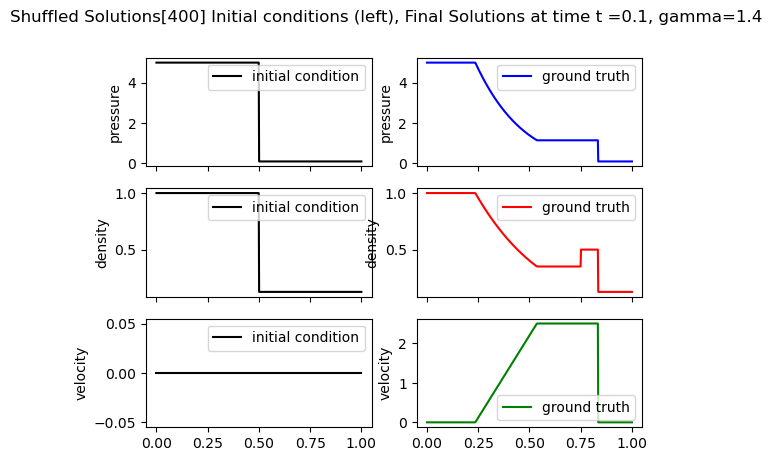

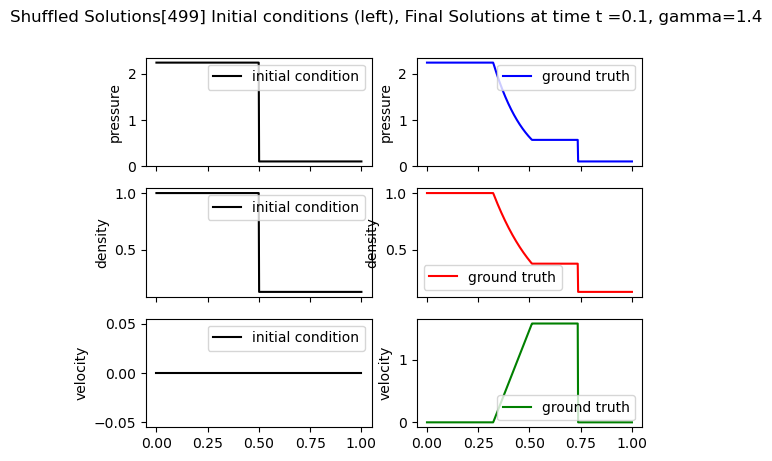

In [59]:
# visualize shuffled solutions 

for n in [0, 100, 200, 300, 400, 499]:
    inputs, outputs, _, _, _ = shuffled_solutions[n]
    x, p_init, rho_init, u_init = inputs
    p_final, rho_final, u_final = outputs
    # Printing p, rho and u for regions

    # Finally, let's plot the solutions
    f, axarr = plt.subplots(3, 2, sharex=True)
    
    #x, p_init, rho_init, u_init = init_conditions
    #p_final, rho_final, u_final = final_sol
    axarr[0][0].plot(x, p_init, label="initial condition", linewidth=1.5, color='k')
    axarr[0][0].set_ylabel('pressure')
    axarr[0][0].legend()
    
    axarr[0][1].plot(x, p_final, label="ground truth", linewidth=1.5, color='b')
    axarr[0][1].set_ylabel('pressure')
    axarr[0][1].legend()
    # axarr[0].set_ylim(0, 5.1)
    
    axarr[1][0].plot(x, rho_init, label="initial condition", linewidth=1.5, color='k')
    axarr[1][0].set_ylabel('density')
    axarr[1][0].legend()
    
    axarr[1][1].plot(x, rho_final, label="ground truth", linewidth=1.5, color='r')
    axarr[1][1].set_ylabel('density')
    axarr[1][1].legend()
    # axarr[1][1].set_ylim(0, 1.1)
    
    axarr[2][0].plot(x, u_init, label="initial condition", linewidth=1.5, color='k')
    axarr[2][0].set_ylabel('velocity')
    axarr[2][0].legend()
    
    axarr[2][1].plot(x, u_final, label="ground truth", linewidth=1.5, color='g')
    axarr[2][1].set_ylabel('velocity')
    axarr[2][1].legend()
        
    plt.suptitle('Shuffled Solutions[{2}] Initial conditions (left), Final Solutions at time t ={0}, gamma={1}'.format(0.1, 1.4, n))
    plt.show()


# Plot Example Initial Conditions and Final Sols

In [60]:
with open(data_path + "{0}_inputs_train.pkl".format(n_sols), "rb") as file:
    inputs_train = pkl.load(file)

with open(data_path +  "{0}_outputs_train.pkl".format(n_sols), "rb") as file:
    outputs_train = pkl.load(file)
    
with open(data_path +  "{0}_inputs_test.pkl".format(n_sols), "rb") as file:
    inputs_test = pkl.load(file)
    
with open(data_path +  "{0}_outputs_test.pkl".format(n_sols), "rb") as file:
    outputs_test = pkl.load(file)

In [61]:
x, p_init, rho_init, u_init = np.array(inputs_train[0])


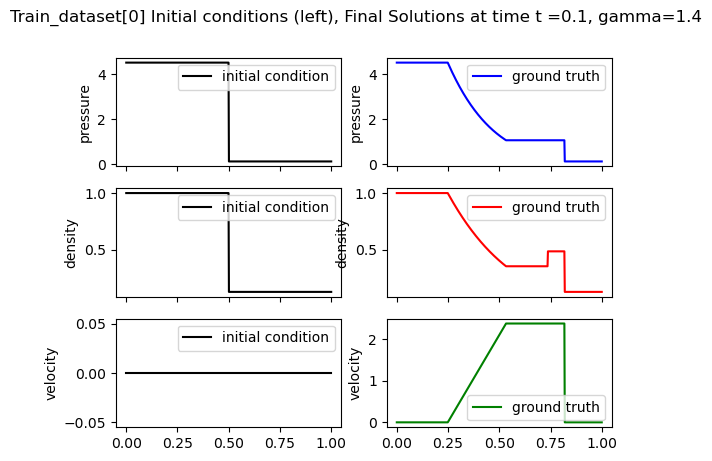

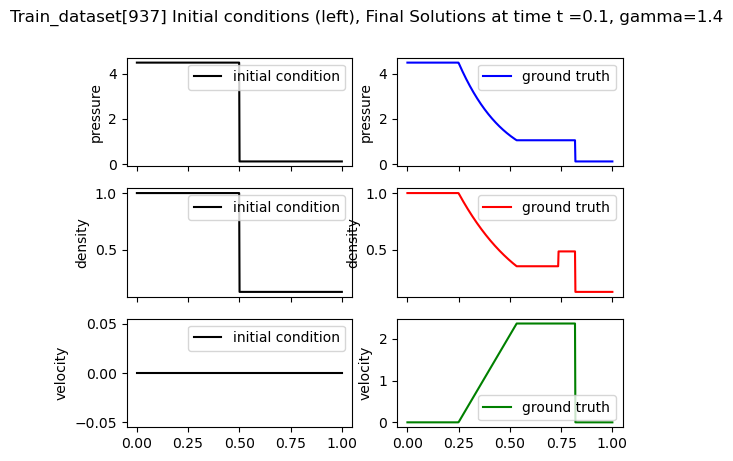

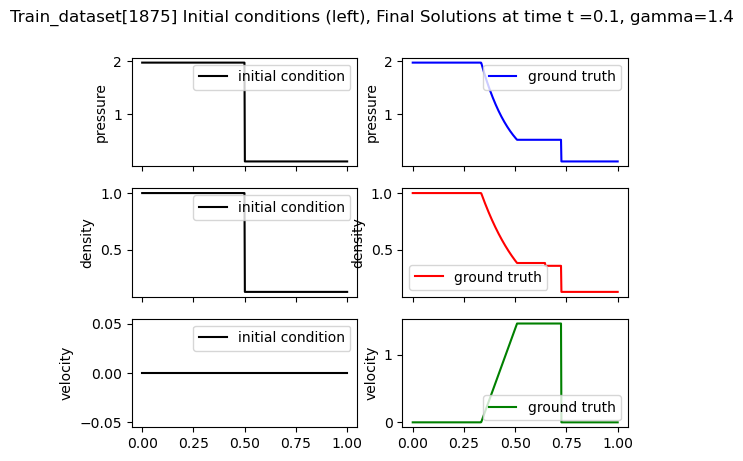

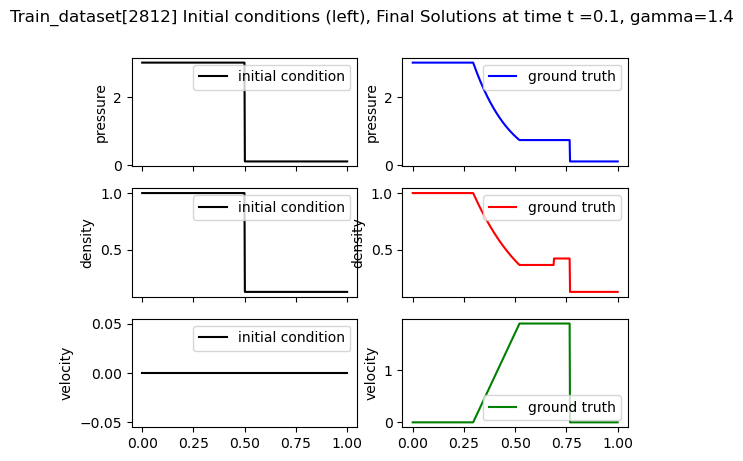

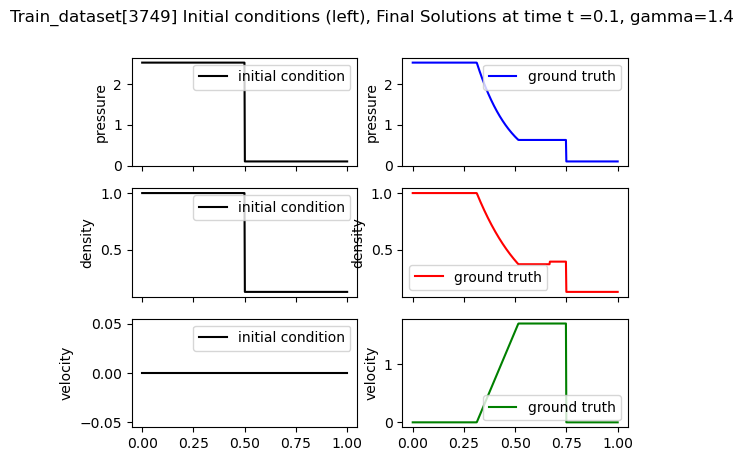

In [62]:
# visualize train dataset

for n in [0, int(train_split/4), int(train_split/2), int(3/4*train_split), train_split-1]:
    x, p_init, rho_init, u_init = inputs_train[n]
    p_final, rho_final, u_final = outputs_train[n]
    # Printing p, rho and u for regions

    # Finally, let's plot the solutions
    f, axarr = plt.subplots(3, 2, sharex=True)
    
    #x, p_init, rho_init, u_init = init_conditions
    #p_final, rho_final, u_final = final_sol
    axarr[0][0].plot(x, p_init, label="initial condition", linewidth=1.5, color='k')
    axarr[0][0].set_ylabel('pressure')
    axarr[0][0].legend()
    
    axarr[0][1].plot(x, p_final, label="ground truth", linewidth=1.5, color='b')
    axarr[0][1].set_ylabel('pressure')
    axarr[0][1].legend()
    # axarr[0].set_ylim(0, 5.1)
    
    axarr[1][0].plot(x, rho_init, label="initial condition", linewidth=1.5, color='k')
    axarr[1][0].set_ylabel('density')
    axarr[1][0].legend()
    
    axarr[1][1].plot(x, rho_final, label="ground truth", linewidth=1.5, color='r')
    axarr[1][1].set_ylabel('density')
    axarr[1][1].legend()
    # axarr[1][1].set_ylim(0, 1.1)
    
    axarr[2][0].plot(x, u_init, label="initial condition", linewidth=1.5, color='k')
    axarr[2][0].set_ylabel('velocity')
    axarr[2][0].legend()
    
    axarr[2][1].plot(x, u_final, label="ground truth", linewidth=1.5, color='g')
    axarr[2][1].set_ylabel('velocity')
    axarr[2][1].legend()
        
    plt.suptitle('Train_dataset[{2}] Initial conditions (left), Final Solutions at time t ={0}, gamma={1}'.format(0.1, 1.4, n))
    plt.show()

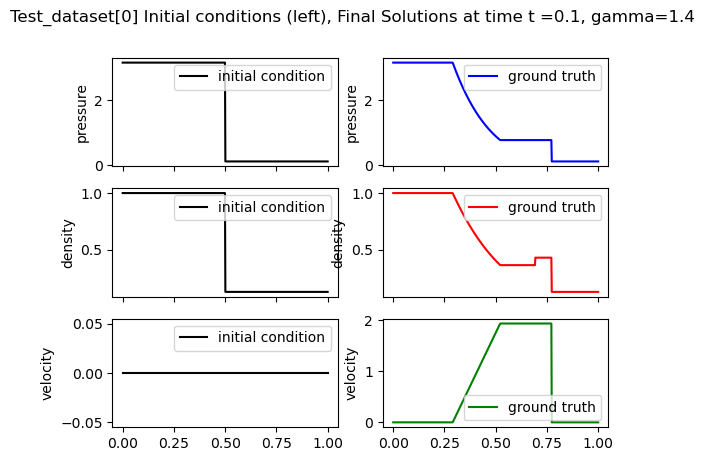

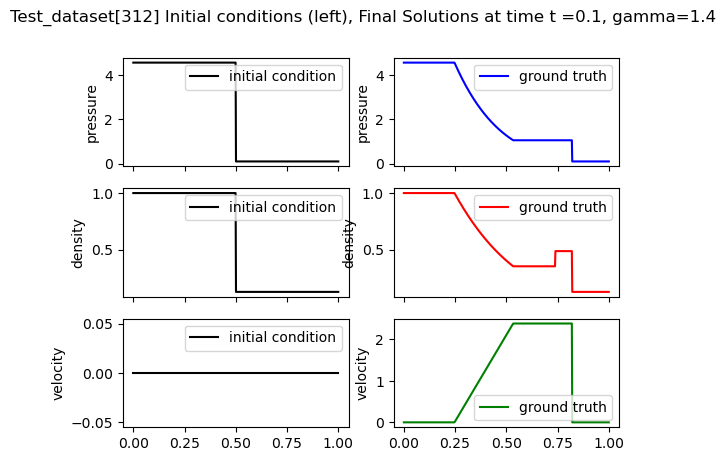

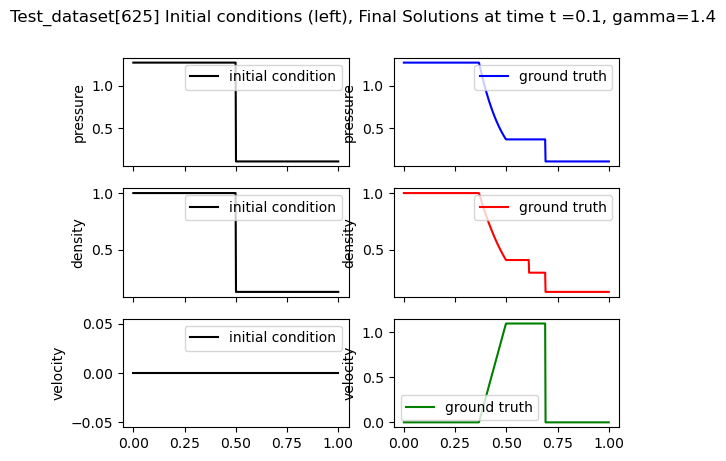

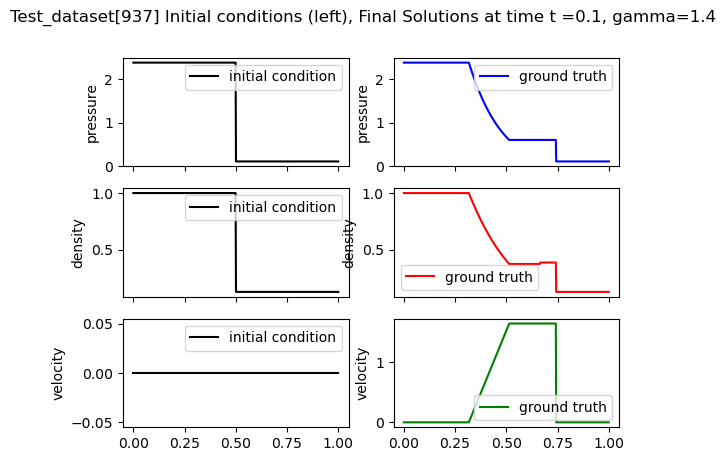

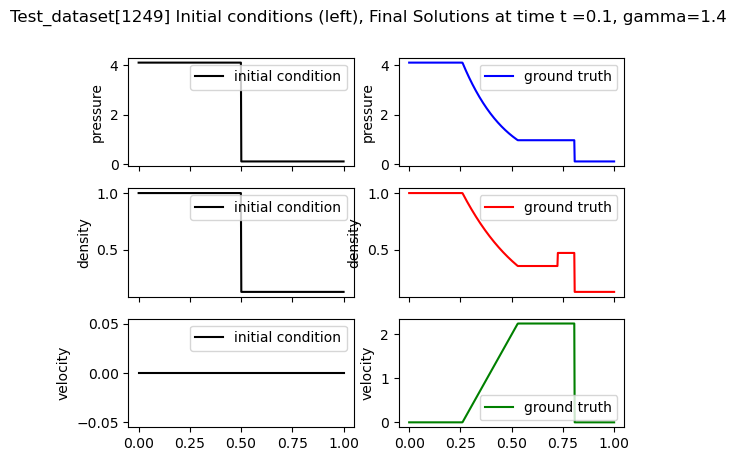

In [63]:
# visualize test dataset
complement = n_sols-train_split
for n in [0, int(complement/4), int(complement/2), int(3/4*complement), complement-1]:
    x, p_init, rho_init, u_init = inputs_test[n]
    p_final, rho_final, u_final = outputs_test[n]
    # Printing p, rho and u for regions

    # Finally, let's plot the solutions
    f, axarr = plt.subplots(3, 2, sharex=True)
    
    #x, p_init, rho_init, u_init = init_conditions
    #p_final, rho_final, u_final = final_sol
    axarr[0][0].plot(x, p_init, label="initial condition", linewidth=1.5, color='k')
    axarr[0][0].set_ylabel('pressure')
    axarr[0][0].legend()
    
    axarr[0][1].plot(x, p_final, label="ground truth", linewidth=1.5, color='b')
    axarr[0][1].set_ylabel('pressure')
    axarr[0][1].legend()
    # axarr[0].set_ylim(0, 5.1)
    
    axarr[1][0].plot(x, rho_init, label="initial condition", linewidth=1.5, color='k')
    axarr[1][0].set_ylabel('density')
    axarr[1][0].legend()
    
    axarr[1][1].plot(x, rho_final, label="ground truth", linewidth=1.5, color='r')
    axarr[1][1].set_ylabel('density')
    axarr[1][1].legend()
    # axarr[1][1].set_ylim(0, 1.1)
    
    axarr[2][0].plot(x, u_init, label="initial condition", linewidth=1.5, color='k')
    axarr[2][0].set_ylabel('velocity')
    axarr[2][0].legend()
    
    axarr[2][1].plot(x, u_final, label="ground truth", linewidth=1.5, color='g')
    axarr[2][1].set_ylabel('velocity')
    axarr[2][1].legend()
        
    plt.suptitle('Test_dataset[{2}] Initial conditions (left), Final Solutions at time t ={0}, gamma={1}'.format(0.1, 1.4, n))
    plt.show()

In [64]:
"""for n in [0, 150, 250, 350, 499]:
    #rng = np.random.default_rng()
    #n = rng.integers(0, 500)
    solution = solutions[n]
    init_conditions, final_sol, positions, regions, states = solution
    # Printing initial conditions
    print("Initial Conditions:")
    print("Left State: " + str(states[0]))
    print("Right State: " + str(states[1]))
    # Printing positions
    print('Positions:')
    for desc, vals in positions.items():
        print('{0:10} : {1}'.format(desc, vals))

    # Printing p, rho and u for regions
    print('Regions:')
    for region, vals in sorted(regions.items()):
        print('{0:10} : {1}'.format(region, vals))

    # Finally, let's plot the solutions
    f, axarr = plt.subplots(3, 1, sharex=True)
    
    x, p_init, rho_init, u_init = init_conditions
    p_final, rho_final, u_final = final_sol
    axarr[0].plot(x, p_final, linewidth=1.5, color='b')
    axarr[0].set_ylabel('pressure')
    # axarr[0].set_ylim(0, 5.1)

    axarr[1].plot(x, rho_final, linewidth=1.5, color='r')
    axarr[1].set_ylabel('density')
    axarr[1].set_ylim(0, 1.1)

    axarr[2].plot(x, u_final, linewidth=1.5, color='g')
    axarr[2].set_ylabel('velocity')
        
    plt.suptitle('Shocktube results at t={0}, gamma={1}'.format(0.1, 1.4))
    plt.show()"""

'for n in [0, 150, 250, 350, 499]:\n    #rng = np.random.default_rng()\n    #n = rng.integers(0, 500)\n    solution = solutions[n]\n    init_conditions, final_sol, positions, regions, states = solution\n    # Printing initial conditions\n    print("Initial Conditions:")\n    print("Left State: " + str(states[0]))\n    print("Right State: " + str(states[1]))\n    # Printing positions\n    print(\'Positions:\')\n    for desc, vals in positions.items():\n        print(\'{0:10} : {1}\'.format(desc, vals))\n\n    # Printing p, rho and u for regions\n    print(\'Regions:\')\n    for region, vals in sorted(regions.items()):\n        print(\'{0:10} : {1}\'.format(region, vals))\n\n    # Finally, let\'s plot the solutions\n    f, axarr = plt.subplots(3, 1, sharex=True)\n    \n    x, p_init, rho_init, u_init = init_conditions\n    p_final, rho_final, u_final = final_sol\n    axarr[0].plot(x, p_final, linewidth=1.5, color=\'b\')\n    axarr[0].set_ylabel(\'pressure\')\n    # axarr[0].set_ylim(0, 5